# Sample program for maximum entropy inverse reinforcement learning. 
This notebook implements maximum entropy inverse reinforcement learning. The algorithms are evaluated on the deterministic [FrozenLake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) provided by the [OpenAI gym](https://github.com/openai/gym). There are 8x8 possible states and 4 discrete deterministic actions.
* https://github.com/yasufumy/python_irl
* https://github.com/yrlu/irl-imitation
* https://github.com/harpribot/IRL-maxent

References
* B. D. Ziebart, A. Maas, J. Andrew Bagnell, and A. K. Dey. (2008). [Maximum Entropy Inverse Reinforcement Learning](https://www.aaai.org/Library/AAAI/2008/aaai08-227.php). In Proc. of AAAI. 
* M. Wulfmeier, D. Rao, D. ZengWang, P. Ondruska,
and I. Posner. (2017). [Large-scale cost function learning for path planning using deep inverse
reinforcement learning](https://doi.org/10.1177/0278364917722396). Internationa Journal of Robotics Research, 36(10): 1073-1087.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
!pip install gymnasium
import gymnasium as gym
# import gym
import random
# from itertools import product
# %matplotlib inline

env = gym.make('FrozenLake-v1', render_mode='ansi', desc=None, map_name='8x8', is_slippery=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Value iteration
Applying the Bellman optimality operator to find the optimal state-action value function. 
$$V(s) \leftarrow \max_a Q(s, a), \quad Q(s, a) = r(s) + \gamma \sum_{s'} p_T (s' \mid s, a) V(s').$$
compute_action_value(state) represents the action value at state "state." The optimal policy is approximated by setting $\beta$ to a large value.
$$\pi (a \mid s) = \frac{\exp (\beta Q(s, a))} {\sum_{a'} \exp (\beta Q(s, a'))},$$


In [13]:
class ValueIteration:
    def __init__(self, env):
        self.env = env

    
    def __call__(self, gamma=0.9, beta=500, epslion=1e-5):
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        V = np.random.rand(n_states)

        def compute_action_value(state):
            qA = np.zeros(n_actions)
            for action in range(n_actions):
                for prob, next_state, reward, done in self.env.P[state][action]:
                    qA[action] += prob * (reward + gamma * V[next_state])
            return qA


        def compute_softmax_policy(beta):
            policy = np.zeros([n_states, n_actions])
            for state in range(n_states):
                policy[state] = beta*compute_action_value(state)
            policy -= policy.max(axis=1, keepdims=True)
            policy = np.exp(policy) / np.exp(policy).sum(axis=1, keepdims=True)

            return policy

        V_error = list([])
        while True:
            delta = 0
            for state in range(n_states):
                qA = compute_action_value(state)
                max_q = qA.max()
                delta = max(delta, np.abs(max_q - V[state]))
                V[state] = max_q
            V_error.append(delta)
            if delta < epslion:
                break

        policy = compute_softmax_policy(beta)

        return V, policy, V_error


def visualize_V(V, V_error):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im1 = axs[0].pcolor(V.reshape(8, 8)[::-1, :])
    axs[0].set_title('state-value function, V')
    axs[0].set_aspect(1.0/axs[0].get_data_ratio(), adjustable='box')
    fig.colorbar(im1, ax=axs[0])
    axs[1].plot(V_error)
    axs[1].set_xlabel('total number of iterations')
    axs[1].set_ylabel('error')
    axs[1].set_title('convergence')

## Calculate the state value and retrieve the policy

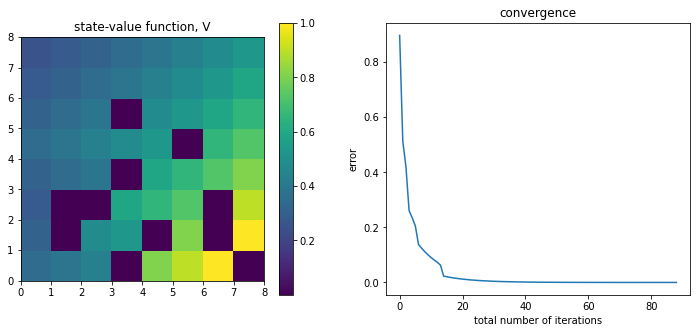

In [14]:
# np.random.seed(seed=0)
value_iteration = ValueIteration(env)
V, policy, V_error = value_iteration(gamma=0.9, beta=500)
visualize_V(V, V_error)

## Show the optimal behavior

In [15]:
state = env.reset()
done = False
total_rewards = 0
while not done:
    print(env.render())
    action = np.random.multinomial(1, policy[state]).argmax()
    state, reward, terminated, truncated, _ = env.step(action)
    total_rewards += reward
print(env.render())
print('total rewards: %f' % (total_rewards))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



IndexError: ignored

## Collect the expert data by running the optimal policy
The expert policy is given by the optimal policy trained with the original reward function. Then, generate a set of state-action sequences to collect the expert data $\mathcal{D}^E = \{ \tau_k \}_{k=1}^{N^E}$, $\tau_k = (s_0^k, s_1^k, \ldots, s_T^k)$.

In [16]:
def sample_trajectories(env, policy, n_steps=10, n_trajectories=100, initial_states=None):
  if initial_states is None:
    states = np.random.choice(np.arange(0, env.nS), n_trajectories)
  else:
    states = initial_states

  trajectories = []
  for state in states:
    env.reset()
    env.s = state
    done = False
    trajectory = []
    for i in range(n_steps):
      action = np.random.multinomial(1, policy[state]).argmax()
      trajectory.append(state)
      state, reward, terminated, truncated, info = env.step(action)
      done = truncated or terminated 
      if done:
        trajectory.extend([state] * (n_steps - len(trajectory)))
        break

      trajectories.append(trajectory)

  return np.array(trajectories)

trajectories = sample_trajectories(env, policy)
print(trajectories)

AttributeError: ignored

## Compute the expected feature count

In [17]:
def compute_feature(n_features, trajectories):
  n_trajectories, n_steps = trajectories.shape
  phi = np.zeros(n_features)
  traj_flatten = trajectories.ravel()
  for state in traj_flatten:
      phi[state] += 1
  phi /= n_trajectories

  return phi

experts_feature = compute_feature(env.nS, trajectories)
#experts_feature = np.load('experts_feature.npy')
print(experts_feature.reshape(4, -1))

AttributeError: ignored

# Maximum entropy inverse reinforcement learning
The probability to generate the state sequence $\tau$ is given by
$$p(\tau \mid w) = \frac{1}{Z(w)} \exp \left( R(\tau; w) \right), \quad Z(w) = \sum_{\tau'} \exp \left( R(\tau'; w) \right), $$
where $R(\tau; w)$ is the total return:
$$R(\tau; w) = \sum_{t=0}^T \gamma^t r(s_t; w), $$
$w$ is the parameter of the reward function, and $\gamma$ is the discount factor. For the given expert data, the log likelihood is calculated by
$$\mathcal{L}(w) = \frac{1}{N^E} \sum_{k=1}^{N^E} \ln p(\tau_k; w).$$
Then, its gradient is given by
$$\nabla_w \mathcal{L}(w) = \frac{1}{N^E} \sum_{k=1}^{N^E} \nabla_w R(\tau_k; w) - \sum_{\tau} p(\tau \mid w) \nabla_w R(\tau; w).$$
The reward parameter is updated by the stochastic gradient ascent. 

In [ ]:
def compute_visitation(env, policy, trajectories):
  n_states = env.nS
  n_actions = env.nA
  probs = env.P
  n_trajectories, n_steps = trajectories.shape

  mu = np.zeros((n_steps, n_states))
  for trajectory in trajectories:
    mu[0, trajectory[0]] += 1
  mu /= n_trajectories

  states = range(n_states)
  actions = range(n_actions)
  for t in range(1, n_steps):
    for state, action in product(states, actions):
      for prob, next_state, _, _ in probs[state][action]:
        mu[t][next_state] += mu[t-1][state] * policy[state][action] * prob

  return mu.sum(axis=0)

class MaxEntIRL:
  def __init__(self, env, experts_feature, trajectories):
    self.env = env
    self.experts_feature = experts_feature
    self.trajectories = trajectories

  def __call__(self, policy, n_epochs, gamma=0.9, beta=500, epsilon=1e-5):
    value_iteration = ValueIteration(self.env)
    reward_function = np.zeros(self.env.nS)
    learning_rate = 0.1

    for i in range(n_epochs):
      V, policy = value_iteration(gamma, beta, epsilon, reward_function=reward_function)
      learners_feature = compute_visitation(self.env, policy, self.trajectories)
      grad = self.experts_feature - learners_feature
      reward_function += learning_rate * grad

    return reward_function, V

In [ ]:
maxent_irl = MaxEntIRL(env, experts_feature, trajectories)
reward_function, V = maxent_irl(policy, n_epochs=50, gamma=0.9)
print(reward_function.reshape(4, 4)[::1, :])
print(V.reshape(4, 4)[::1, :])

## Show results.

In [ ]:
def plot_results(reward_function, V):
  fig, axs = plt.subplots(1, 2, figsize=(10, 4))
  im1 = axs[0].pcolor(reward_function.reshape(4, 4)[::-1, :])
  axs[0].set_title('reward function')
  fig.colorbar(im1, ax=axs[0])
  im2 = axs[1].pcolor(V.reshape(4, 4)[::-1, :])
  axs[1].set_title('value function')
  fig.colorbar(im2, ax=axs[1])
  plt.show()

plot_results(reward_function, V)

# Modified maximum inverse reinforcement learning

The second term of the gradient of the log likelihood is approximated using samples generated by the learner's policy:
$$\nabla_w \mathcal{L}(w) = \frac{1}{N^E} \sum_{k=1}^{N^E} \nabla_w R(\tau_k; w) - \frac{1}{N^L} \sum_{j=1}^{N^L} \nabla_w R(\tau_j; w)$$

In [ ]:
class MaxEntIRLSample:
  def __init__(self, env, experts_feature, trajectories):
    self.env = env
    self.experts_feature = experts_feature
    self.n_trajectories, self.n_steps = trajectories.shape
    self.initial_states = trajectories[:, 0]

  def __call__(self, policy, n_epochs, gamma=0.9, beta=500, epsilon=1e-5):
    value_iteration = ValueIteration(self.env)
    reward_function = np.zeros(self.env.nS)
    learning_rate = 0.1

    for i in range(n_epochs):
      V, policy = value_iteration(gamma, beta, epsilon, reward_function)
      trajectories = sample_trajectories(self.env, policy, self.n_steps,
                                         self.n_trajectories,
                                         self.initial_states)
      learners_feature = compute_feature(self.env.nS, trajectories)
      grad = self.experts_feature - learners_feature
      reward_function += learning_rate * grad

    return reward_function, V

In [ ]:
maxent_irl_sample = MaxEntIRLSample(env, experts_feature, trajectories)
reward_function, V = maxent_irl_sample(policy, n_epochs=50, gamma=0.9)
# print(reward_function.reshape(4, 4)[::1, :])
# print(V.reshape(4, 4)[::1, :])
plot_results(reward_function, V)